# Cell trajectory

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.5
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints                 0.3
h5py                        3.6.0
igraph          

In [4]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


In [5]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [6]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

In [7]:
adata.X

array([[0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 3., ..., 2., 3., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [3., 0., 3., ..., 0., 1., 0.],
       [0., 0., 4., ..., 1., 1., 1.]])

## Processing and Visualisation

Normalizzazione e filtraggio come in Zheng[17], riproduce il preprocessing di Cell Ranger R Kit of 10x Genomics.
Successivamente esegue pca e calcola il neighborhood graph. Plotta il grafo, che risulta abbastanza disordinato.

In [8]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:01)


computing neighbors
    using 'X_pca' with n_pcs = 20


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:17)


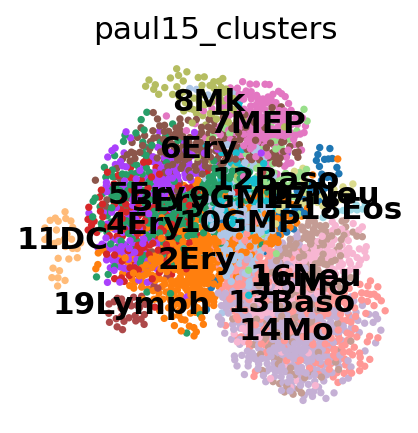

In [10]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

## Denoising the graph

Per diminuire il rumore del grafo, lo rappresentiamo nello spazio della mappa di diffusione (e non nello spazio PCA). Il calcolo delle distanze all'interno di alcune componenti di diffusione equivale a ridurre il rumore del grafico: prendiamo solo alcune delle prime componenti spettrali.\
Lo step non è necessario ma a volte da dei buoni risultati.

In [11]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [12]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:17)


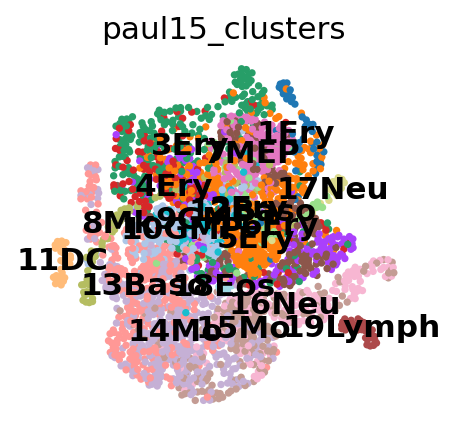

In [13]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

## Clustering and PAGA

Usano louvain ma sarebbe meglio usare leiden\
Dopo di che vengono annotati i cluster usando i geni marker.
- HSCs;	Procr
- Erythroids;	Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1
- Neutrophils;	Elane, Cebpe, Ctsg, Mpo, Gfi1
- Monocytes;	Irf8, Csf1r, Ctsg, Mpo
- Megakaryocytes;	Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf
- Basophils;	Mcpt8, Prss34
- B cells;	Cd19, Vpreb2, Cd79a
- Mast cells;	Cma1, Gzmb, CD117/C-Kit
- Mast cells & Basophils;	Ms4a2, Fcer1a, Cpa3, CD203c (human)

Dopo di che viene eseguito PAGA (che avevamo già visto) e disegnato il suo grafico.\
Ciò viene fatto per avere una visualizzazione semplice e a grana grossa, calcolando un grafo quindi semplificato.


In [14]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [15]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


Dal paper somiglia all'ordinamento su una dimensione e ordinati in maniera astratta in un grafo

/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


--> added 'pos', the PAGA positions (adata.uns['paga'])


/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


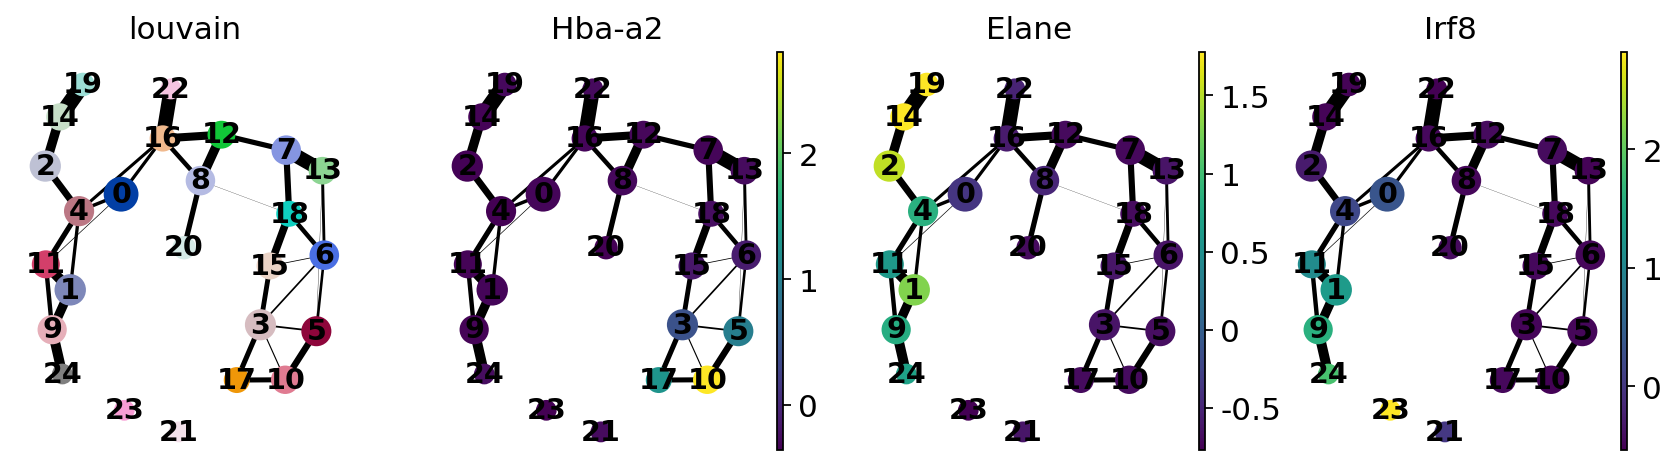

In [16]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


--> added 'pos', the PAGA positions (adata.uns['paga'])


/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


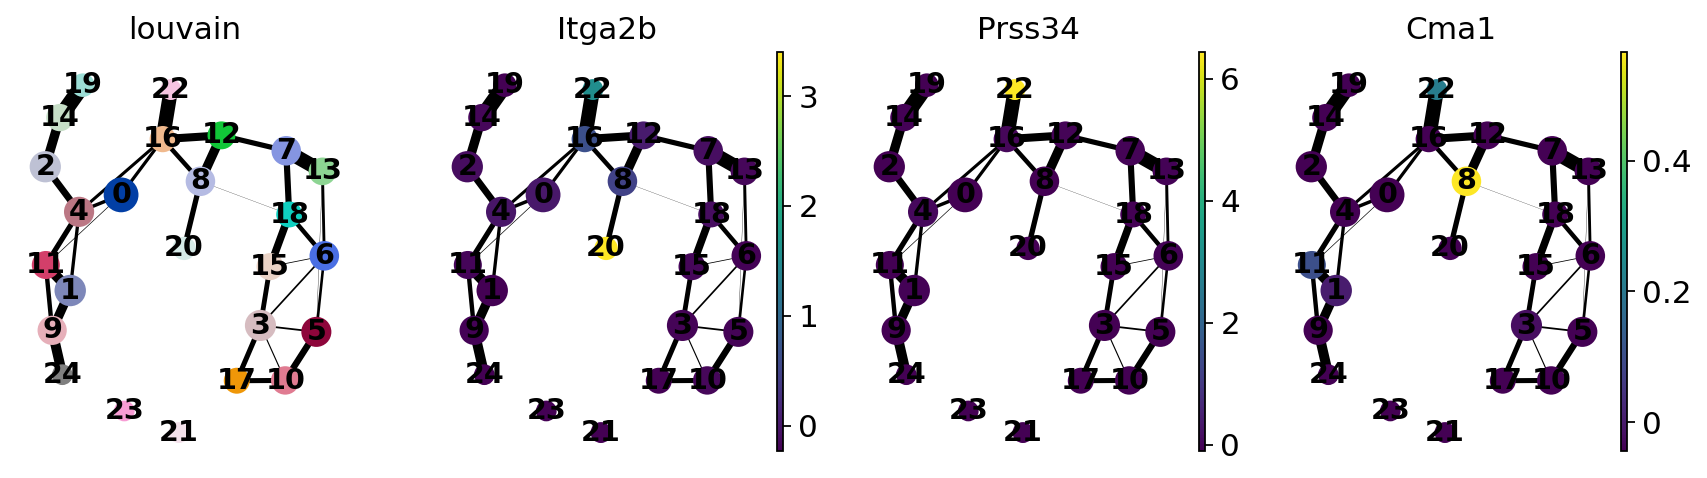

In [17]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Vengono effettivamente annotati i cluster

In [18]:
adata.obs['louvain'].cat.categories
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

E poi si computa il grafo PAGA annotato

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes:>

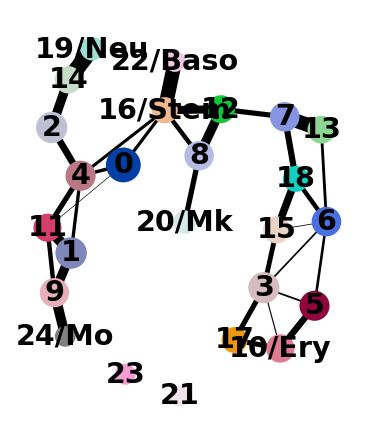

In [19]:
sc.tl.paga(adata, groups='louvain_anno')
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization
Ora cerchiamo di vedere tutti i marker anche alla risoluzione di una singola cellula, in un layout significativo.

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:08)


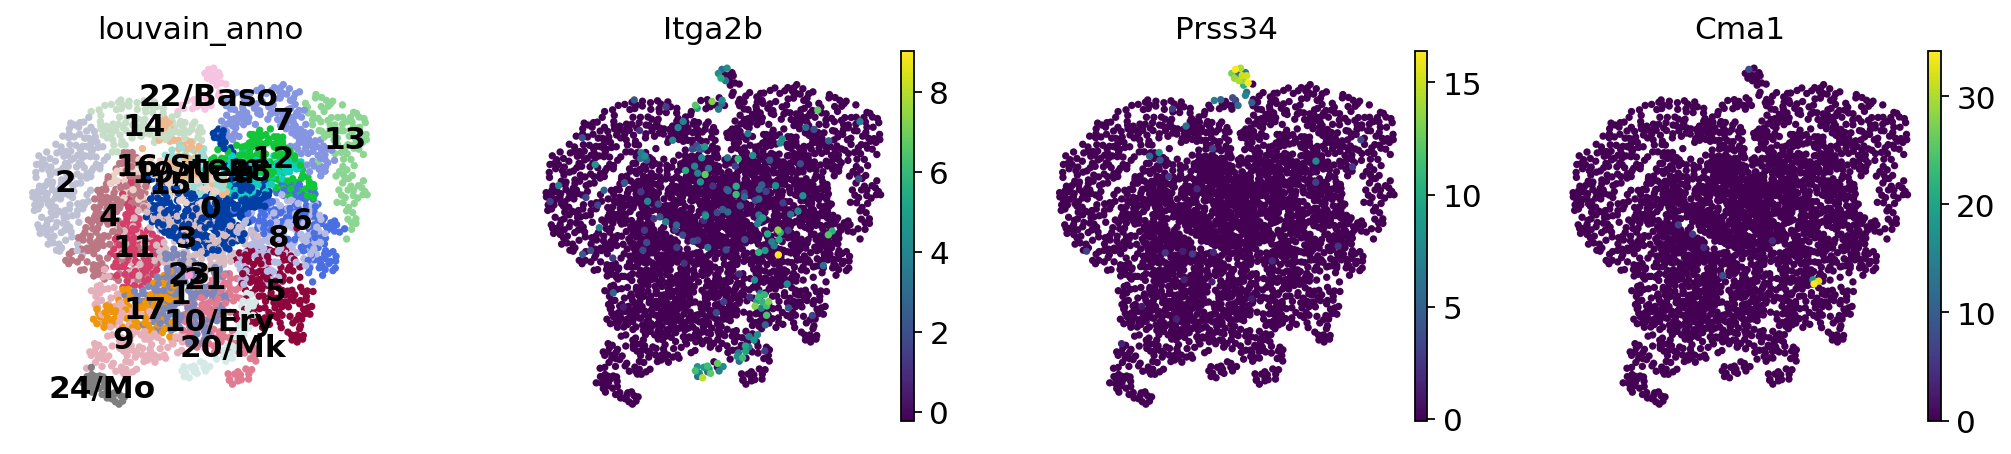

In [20]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Sceglie colori più consistenti per i cluster

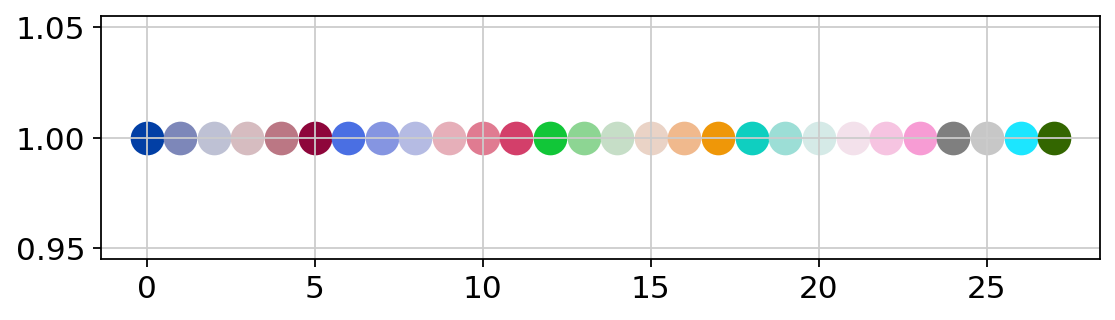

In [21]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [22]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [23]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey
adata.uns['louvain_anno_colors'] = new_colors

Abbiamo dovuto cambiare il layout mentre passavamo da una PCA randomizzata e da float32 a una precisione float64.\
Visualizziamo uno scatter e un grafico PAGA affiancati.
Così abbiamo sia un grafico a dispersione sia un grafico astratto.

--> added 'pos', the PAGA positions (adata.uns['paga'])


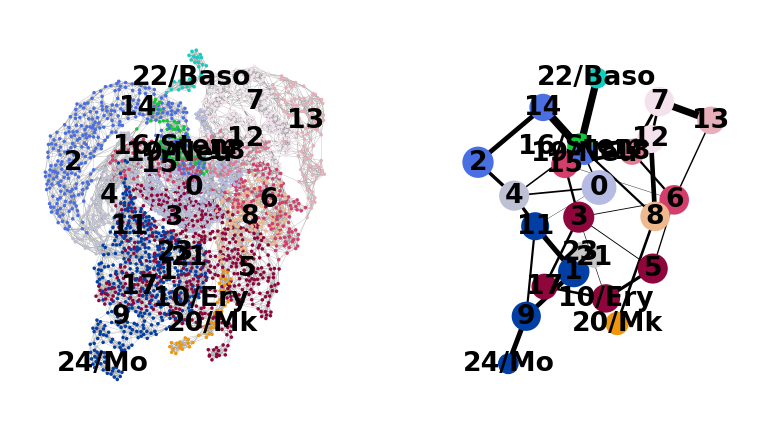

In [24]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

Scegli una cellula radice per lo pseudotempo di diffusione e poi i nomi dei marker.\
Deduciamo la progressione delle cellule attraverso la distanza geodetica lungo il grafico.

Distanza geodetica = Le geodetiche di una superficie sferica sono costituite da circonferenze di raggio massimo. La distanza tra due punti di una superficie è data dalla lunghezza del tratto di geodetica che li congiunge.

Ricostruire la progressione di un processo biologico da dati snapshot. Lo pseudotempo di diffusione è stato introdotto da [Haghverdi16] e implementato all'interno di Scanpy [Wolf18]. Qui, utilizziamo una versione ulteriormente sviluppata, che è in grado di gestire grafici disconnessi [Wolf19] e può essere eseguita in modalità gerarchica impostando il parametro n_branchings>1. Raccomandiamo, tuttavia, di utilizzare solo dpt() per il calcolo dello pseudotempo (n_branchings=0) e di rilevare le ramificazioni tramite paga(). Per lo pseudotempo, devi annotare i tuoi dati con una cella radice.

In [25]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]
sc.tl.dpt(adata)
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


... storing 'paul15_clusters' as categorical
/home/chiara/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


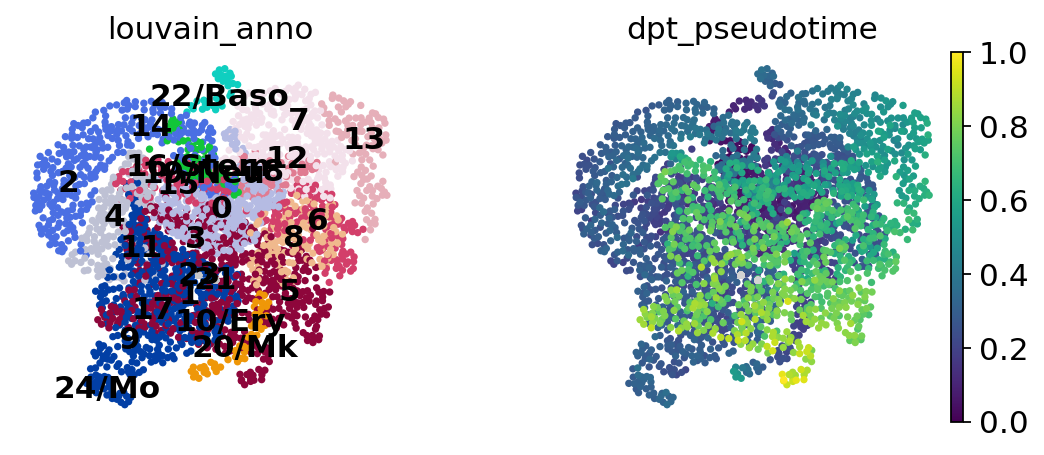

In [26]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [27]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]
adata.obs['distance'] = adata.obs['dpt_pseudotime']
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1226: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/home/chiara/anaconda3/envs/scan/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1273: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


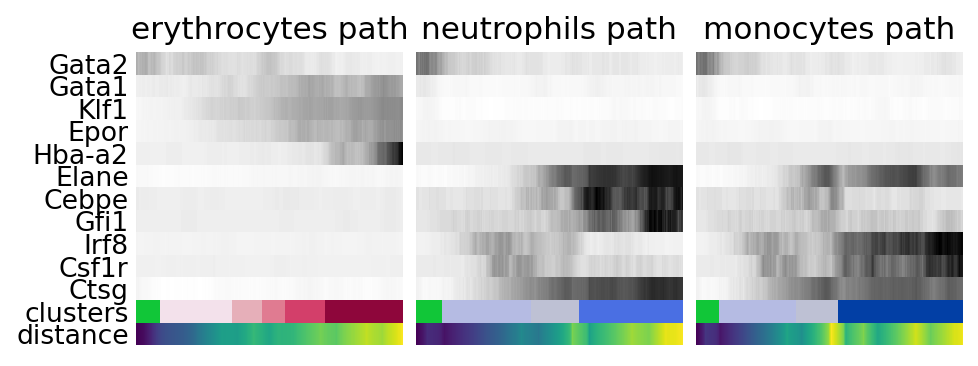

In [30]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()